# **Credits**
Creator: Long Vo <br>
Date: 10/18/2022 <br>
<br>

In [16]:
import random
import six
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### File Separation:

In [103]:
# load dataset
train_data = np.loadtxt('../HW2_material/MNISTnumImages5000_balanced.txt', dtype=float)
train_labels = np.loadtxt('../HW2_material/MNISTnumLabels5000_balanced.txt', dtype=float)

In [104]:
# this function used to read and separate image data based on its label
def create_file(i):
    currentFile = open('../assets/' + str(i) + '.txt', 'w')
    img = [train_data[key] for (key, label) in enumerate(train_labels) if int(label) == i]
    data = ""
    for i in range(len(img)):
        for j in range(len(img[i])):
            temp_data = str(img[i][j])
            data += temp_data + "\t"
        data += "\n"
    currentFile.write(data)
    currentFile.close()

# this function is used to take 400 label-digits of 0 and 1 to combine into 1 training_dataset
def combine_lst(num_label):
    img = [train_data[key] for (key, label) in enumerate(train_labels) if int(label) == num_label]
    # to keep track of label, we will then add the label to the end of image
    for i in range(len(img)):
        img[i] = np.append(img[i], num_label)
    res = list()
    for i in range(400):
        res.append(img[i])
    return res

training_dataset = combine_lst(0) + combine_lst(1)
random.shuffle(training_dataset)


def make_dataset(num_label): 
    img = [train_data[key] for (key, label) in enumerate(train_labels) if int(label) == num_label]
    for i in range(len(img)):
        img[i] = np.append(img[i], num_label)
    res = list()
    for i in range(400, 500):
        res.append(img[i])
    return res


test_dataset = list()
challenge_dataset = list()


for i in range(10):
    if i == 0 or i == 1:
        test_dataset += make_dataset(i)
    elif i in [n for n in range(2, 10)]:
        challenge_dataset += make_dataset(i)
        
random.shuffle(challenge_dataset)
random.shuffle(test_dataset)

def create_dataset(name, dataset):
    currentFile = open('../assets/' + name + '.txt', 'w')
    data = ""
    for i in range(len(dataset)):
        for j in range(len(dataset[i])):
            temp_data = str(dataset[i][j])
            data += temp_data + "\t"
        data += "\n"
    currentFile.write(data)
    currentFile.close()    

In [105]:
# Create data files
for i in range(10):
    if i == 0 or i == 1 or i == 7 or i == 9:
        create_file(i)
create_dataset('challenge_dataset', challenge_dataset)
create_dataset('test_dataset', test_dataset)
create_dataset('training_dataset', training_dataset)

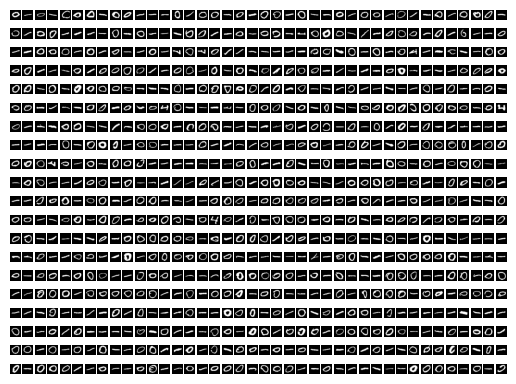

In [106]:
# for testing purpose
file_test = np.loadtxt('../assets/training_dataset.txt', dtype=float)
for i in range(0, 800):
    image = file_test[i][0:784].reshape((28, 28))
    plt.subplot(20, 40, i + 1)
    plt.imshow(image, cmap="gray")
    plt.axis('off')
plt.show()

# **Problem 1:**

### Threshold Generator:

In [107]:
train_ds = np.loadtxt('../assets/training_dataset.txt', dtype=float)
test_ds = np.loadtxt('../assets/test_dataset.txt', dtype=float)
challenge_ds = np.loadtxt('../assets/challenge_dataset.txt', dtype=float)

# initialize variables
w = np.random.uniform(0, 0.5, [784])
w_init = w.copy()
learning_rate = 0.01
EPOCH = 40

# binary threshold neuron
def threshold():
    teaching_rate = 0
    np.random.shuffle(train_ds)
    
    for t, image in enumerate(train_ds):
        teaching_rate = int(image[784])
        for j, x in enumerate(w): # x is weight
            # hebb rule
            x = x + learning_rate * teaching_rate * (train_ds[t][j] - x)
            w[j] = x

In [108]:
for _ in range(EPOCH):
    threshold()

### Confusion Matrix

In [109]:
def confused_matrix():
    precision, recall, f1_score, true_pos, false_pos, confuse_value = [], [], [], [], [], [] 
    for i in range(40): # theta is 40
        tp, tn, fp, fn = 0, 0, 0, 0
        for j, iput in enumerate(test_ds):
            y_label = iput[784]
            value_input = np.dot(np.transpose(iput[0:784]), w)
            y_value = 1 if value_input > i else 0
            if y_value == 1:
                if y_label == 1:
                    tp += 1
                else:
                    fp += 1
            elif y_value == 0:
                if y_label == 1:
                    fn += 1
                else:
                    tn += 1
                    
        true_pos.append(tp)
        false_pos.append(fp)
        
        try:
            precision.append(tp / (tp + fp))
            recall.append(tp / (tp + fn))
            f1_score.append((2 * (precision[i] * recall[i])) / (precision[i] + recall[i]))
        except ZeroDivisionError:
            pass
        
        confuse_value.append([i,tp,tn,fp,fn])
        
    return [precision, recall, f1_score, true_pos, false_pos, confuse_value]         

### Precision, Recall, F1 Score, ROC diagram

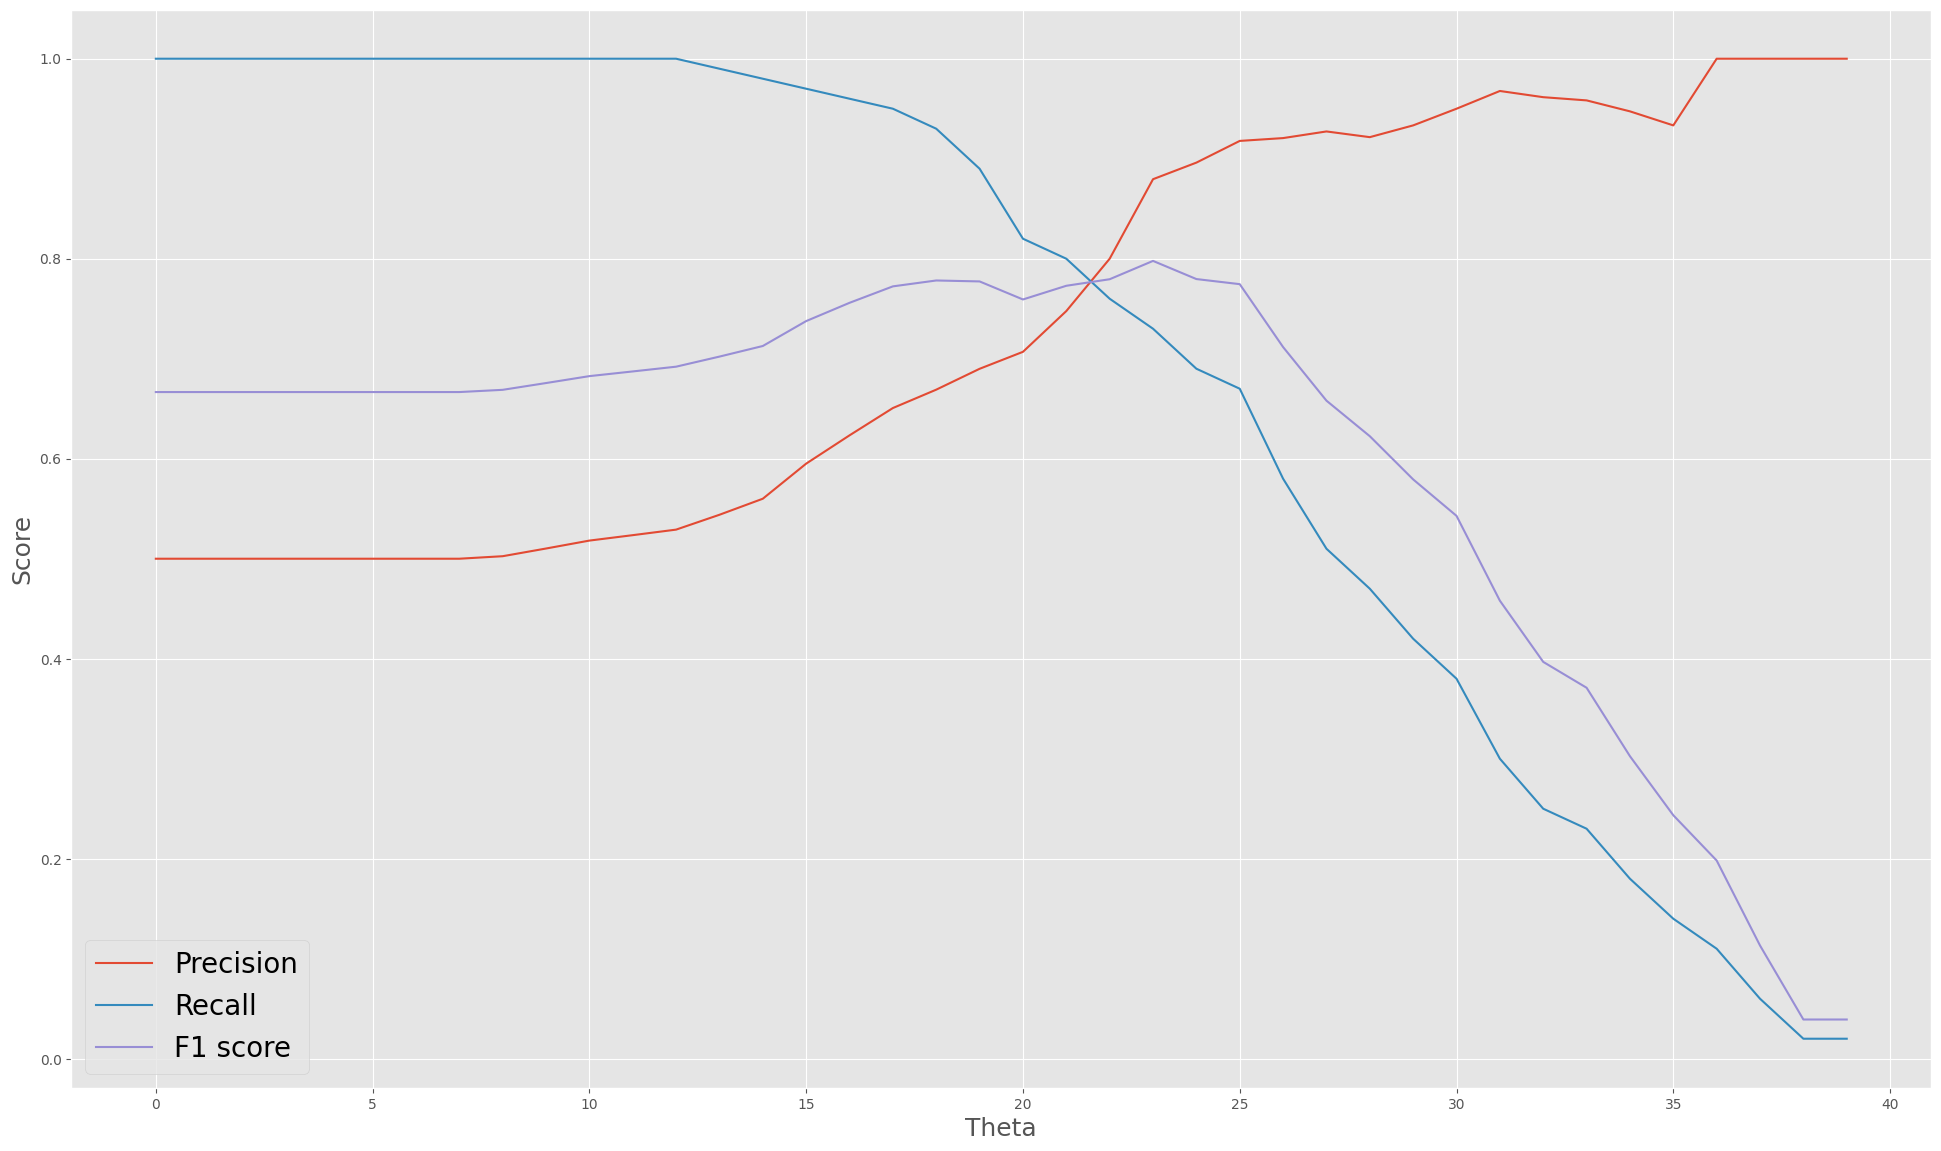

In [110]:
evaluation = confused_matrix()
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(24, 14))
labels_graph = ['Precision', 'Recall', 'F1 score']
plt.style.use('ggplot')

# precision, recall, f1 score
for i in range(3):
    plt.plot([j for j in range(40)], evaluation[i], label= labels_graph[i])
plt.legend(prop={'size': 20})
   
plt.xlabel('Theta', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.savefig('../assets/figure1.png')
plt.show()

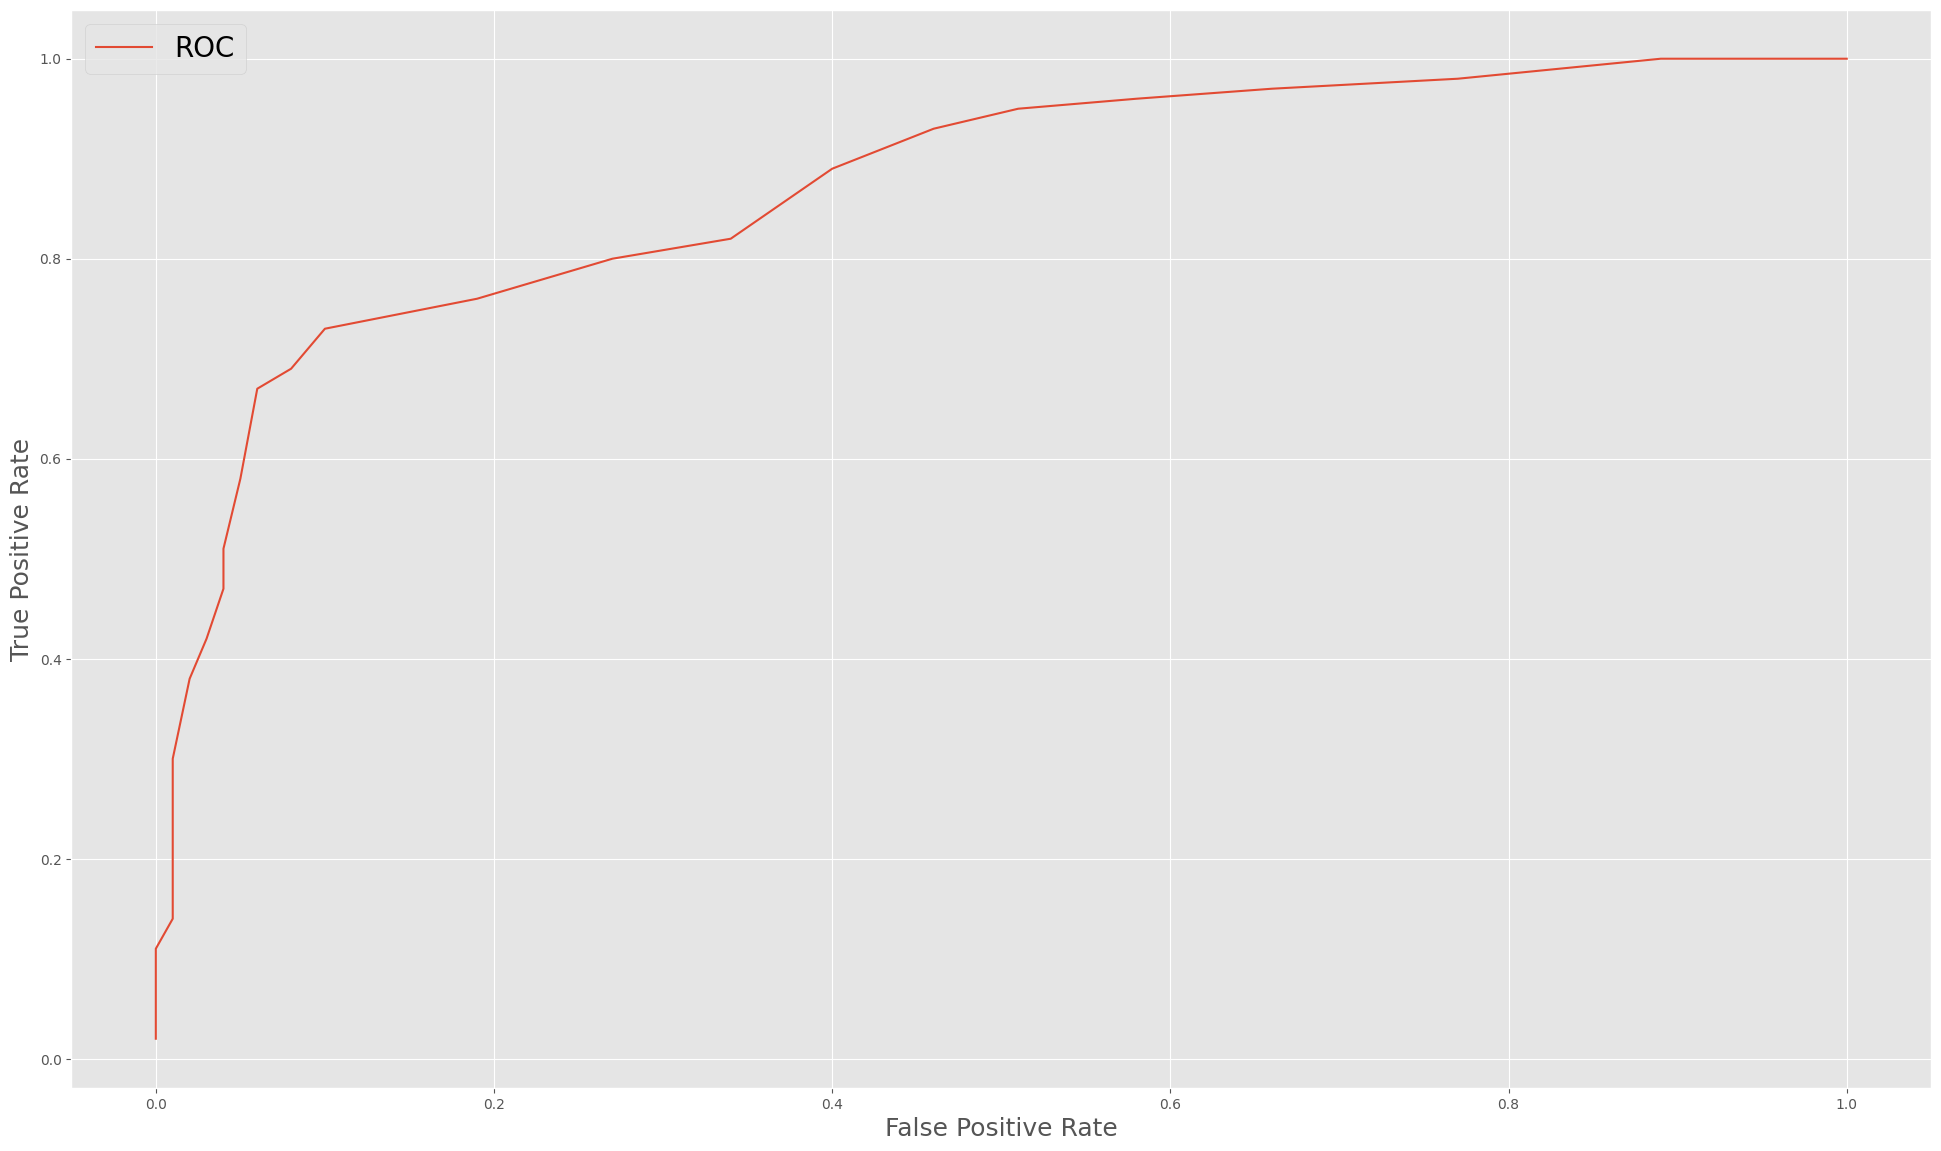

In [111]:
fig = plt.subplots(1, 1, sharex=True, figsize=(24, 14))
true_pos = [i/100 for i in evaluation[3]]
false_pos = [i/100 for i in evaluation[4]]
plt.style.use('ggplot')
plt.plot(false_pos, true_pos, label='ROC')
plt.legend(prop={'size': 20})
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.savefig('../assets/figure2.png')
plt.show()

### Heat Map

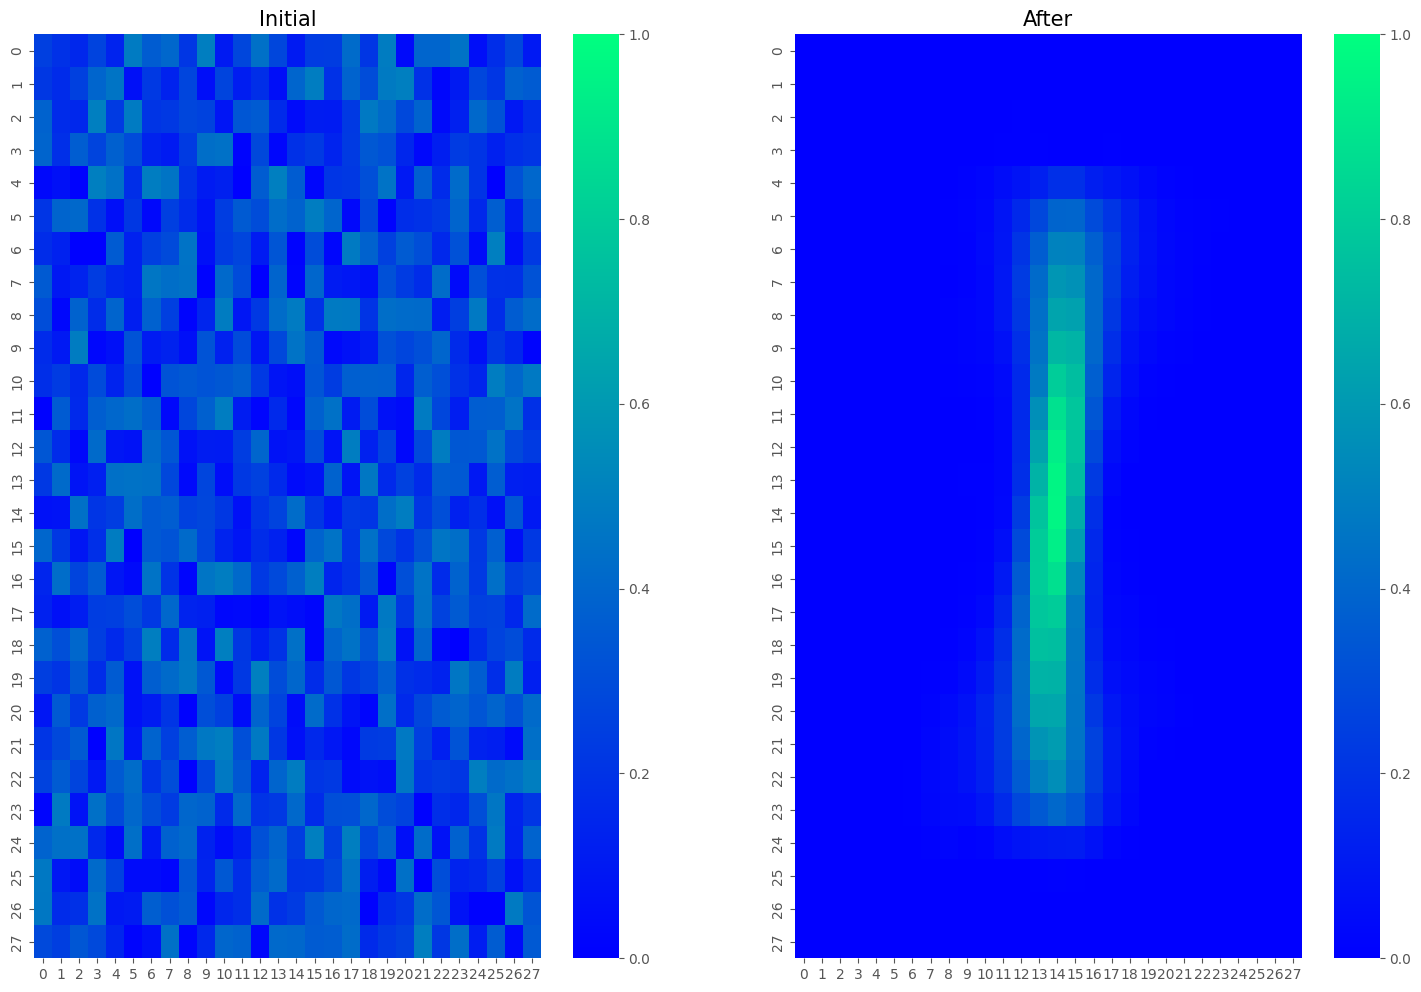

In [112]:
init_w = np.asarray(w_init)
final_w = np.asarray(w)
init_w_img = init_w.reshape(28, 28)
final_w_img = final_w.reshape(28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

sns.heatmap(init_w_img, ax=ax1, vmin=0, vmax=1, cmap = 'winter')
sns.heatmap(np.transpose(final_w_img), ax=ax2, vmin=0, vmax=1, cmap = 'winter')
ax1.set_title('Initial', fontsize=15)
ax2.set_title('After', fontsize=15)
plt.savefig('../assets/figure3.png')
plt.show()

### Optimal Threshold

In [129]:
# estimate optimal threshold value
val_threshold = []
for i in range(len(false_pos)):
    val_threshold.append(true_pos[i] - false_pos[i])

opt_idx = val_threshold.index(max(val_threshold))
print(f'Optimal threshold theta: {opt_idx}')

def optimal_threshold():
    global opt_idx
    thres_dict = {2 : [0, 0], 3 : [0, 0],
                  4 : [0, 0], 5 : [0, 0],
                  6 : [0, 0], 7 : [0, 0],
                  8 : [0, 0], 9 : [0, 0]}
    for counter, x in enumerate(challenge_ds):
        y_label = int(x[784])
        challenge_input = np.dot(np.transpose(x[0:784]), w)
        y_value = 1 if challenge_input > opt_idx else 0
        if y_value == 0:
            thres_dict[y_label][0] += 1
        elif y_value == 1:
            thres_dict[y_label][1] += 1
    df = pd.DataFrame(thres_dict)
    return df

print(optimal_threshold())

Optimal threshold theta: 23
    2   3   4   5   6   7   8   9
0  51  49  84  78  54  68  17  72
1  49  51  16  22  46  32  83  28


# **Problem 2**

### Perceptron and Graph of test error vs training error

In [114]:
EPOCH = 100

def perceptron():
    
    bias = 1
    w = np.random.uniform(0, 0.5, (784))
    w_init = w.copy()
    learning_rate = 0.001
    training_error = list()
    test_error = list()
    bias_update = list()
    
    for i in range(EPOCH):
        error = 0
        error_test = 0
        np.random.shuffle(train_ds)
        for t, image in enumerate(train_ds):
            x = image[0:784]
            y = int(image[784])
            s = np.dot(np.transpose(x), w) + bias
            y_value = 1 if s > 0 else 0 # activation
            if y_value != int(y):
                error += 1
            # perceptron function
            w = w + learning_rate * (y - y_value) * x
            bias = bias + learning_rate * (y - y_value)
        training_error.append(float(error/800.0))
        bias_update.append(bias)
    
        for t, image in enumerate(test_ds):
            y = int(image[784])
            s = np.dot(np.transpose(image[0:784]), w) + bias
            y_value = 1 if s > 0 else 0
            if y_value != int(y):
                error_test += 1

        test_error.append(float(error_test/200.0))
   
    return [training_error, test_error, w, w_init, bias_update]        

[0.5, 0.125, 0.07, 0.035, 0.02, 0.02, 0.02, 0.02, 0.015, 0.015, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005]


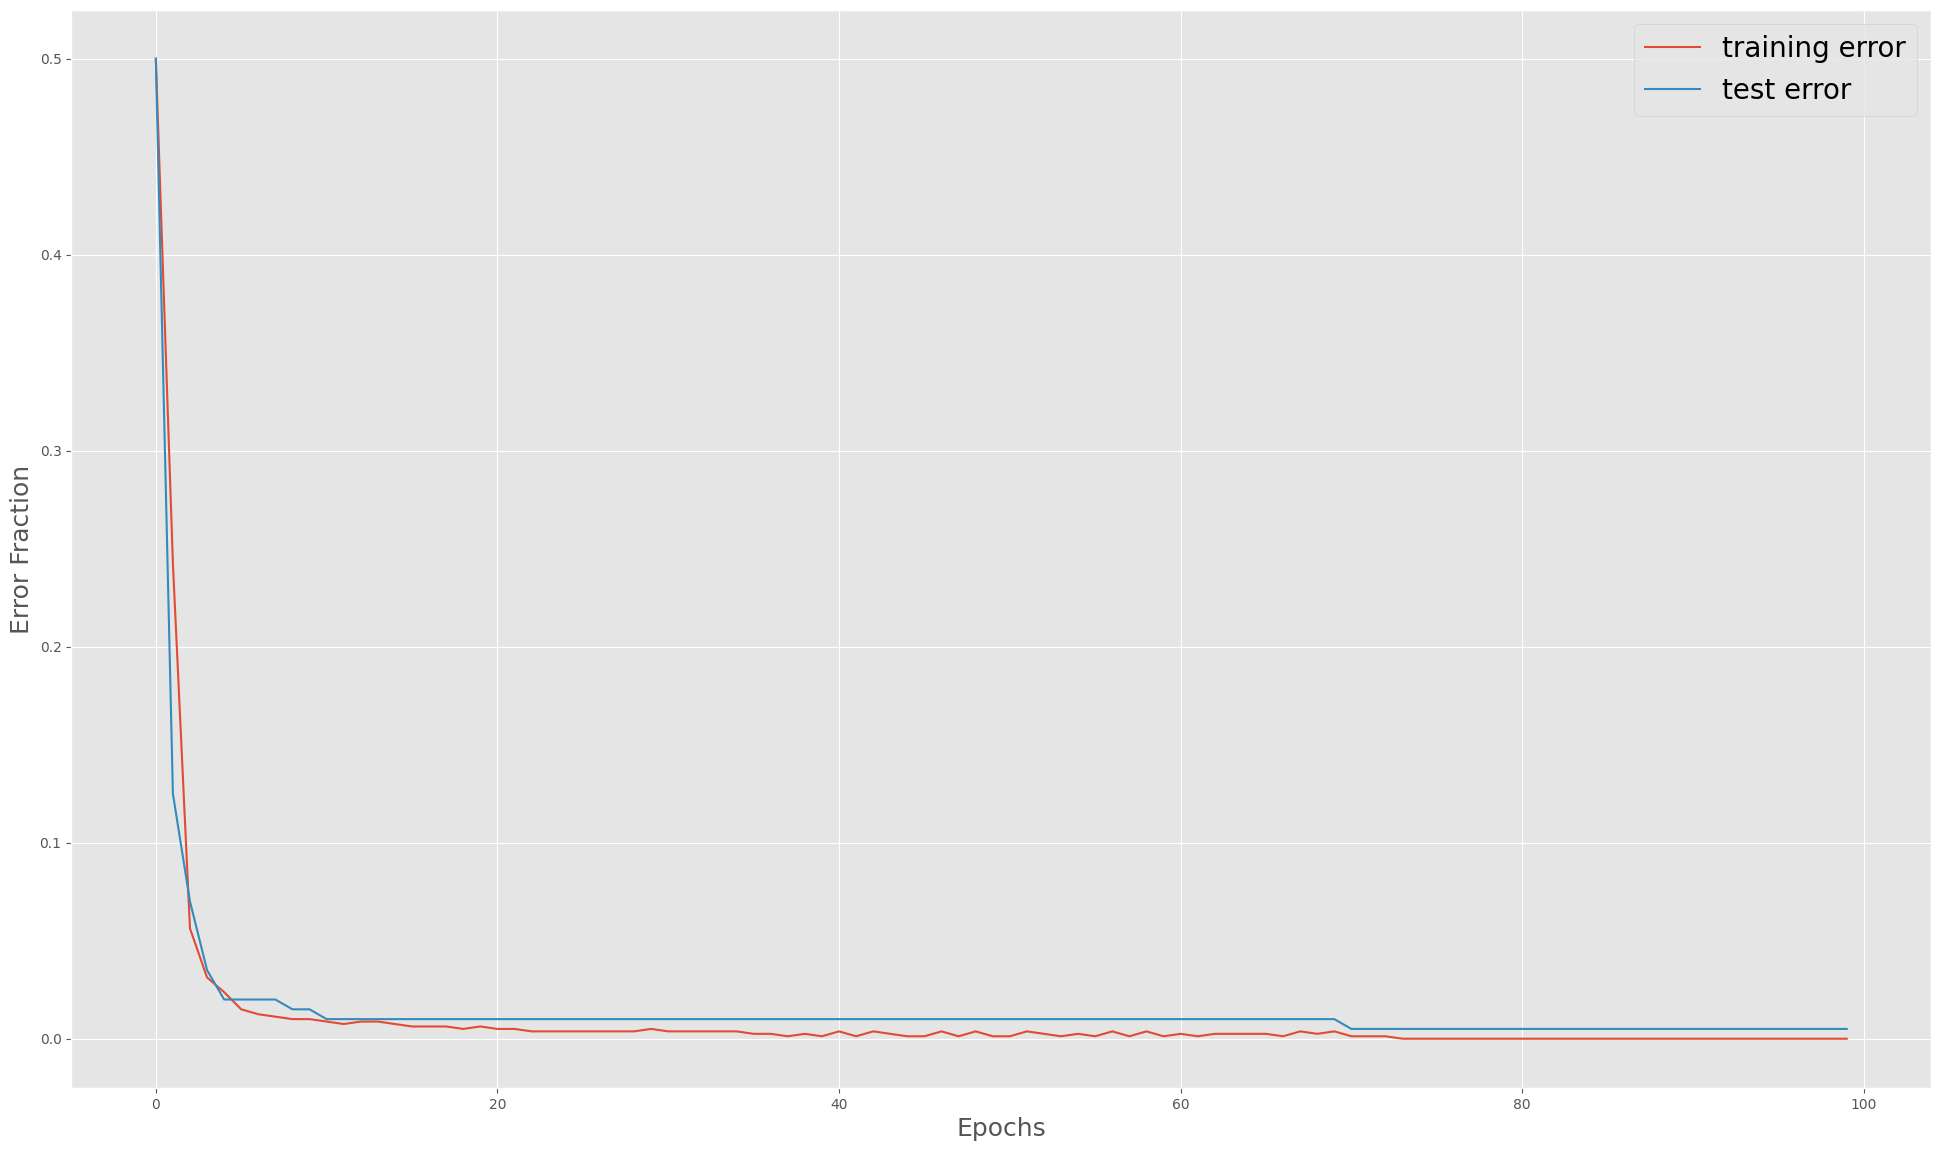

In [124]:
values = perceptron()
# print(values[1]) # to see the value of test error
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(24, 14))
graph_labels = ['training error', 'test error']
count = 0
plt.style.use('ggplot')
for i in values:
    if count == 2: break
    plt.plot([j for j in range(100)], i, label=graph_labels[count])
    count += 1
plt.legend(prop={'size': 20})
plt.ylabel('Error Fraction', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.savefig('../assets/figure4.png')
plt.show()

### Perceptron Confusion Matrix

In [125]:
def perceptron_conf(weight):
    precision, recall, f1_score, true_pos, false_pos, confuse_value = 0, 0, 0, 0, 0, []
    tp, tn, fp, fn = 0, 0, 0, 0
    for j, iput in enumerate(test_ds):
        y_label = iput[784]
        value_input = np.dot(np.transpose(iput[0:784]), weight) + values[4][-1] # bias
        y_value = 1 if value_input > 0 else 0
        if y_value == 1:
            if y_label == 1:
                tp += 1
            else:
                fp += 1
        elif y_value == 0:
            if y_label == 1:
                fn += 1
            else:
                tn += 1
                
    true_pos = tp
    false_pos = fp
    
    try:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = (2 * (precision * recall)) / (precision + recall)
    except ZeroDivisionError:
        pass
    
    confuse_value.append([i,tp,tn,fp,fn])
        
    return [precision, recall, f1_score, true_pos, false_pos, confuse_value]       
    

### Bar plot of precision, recall, and f1 score

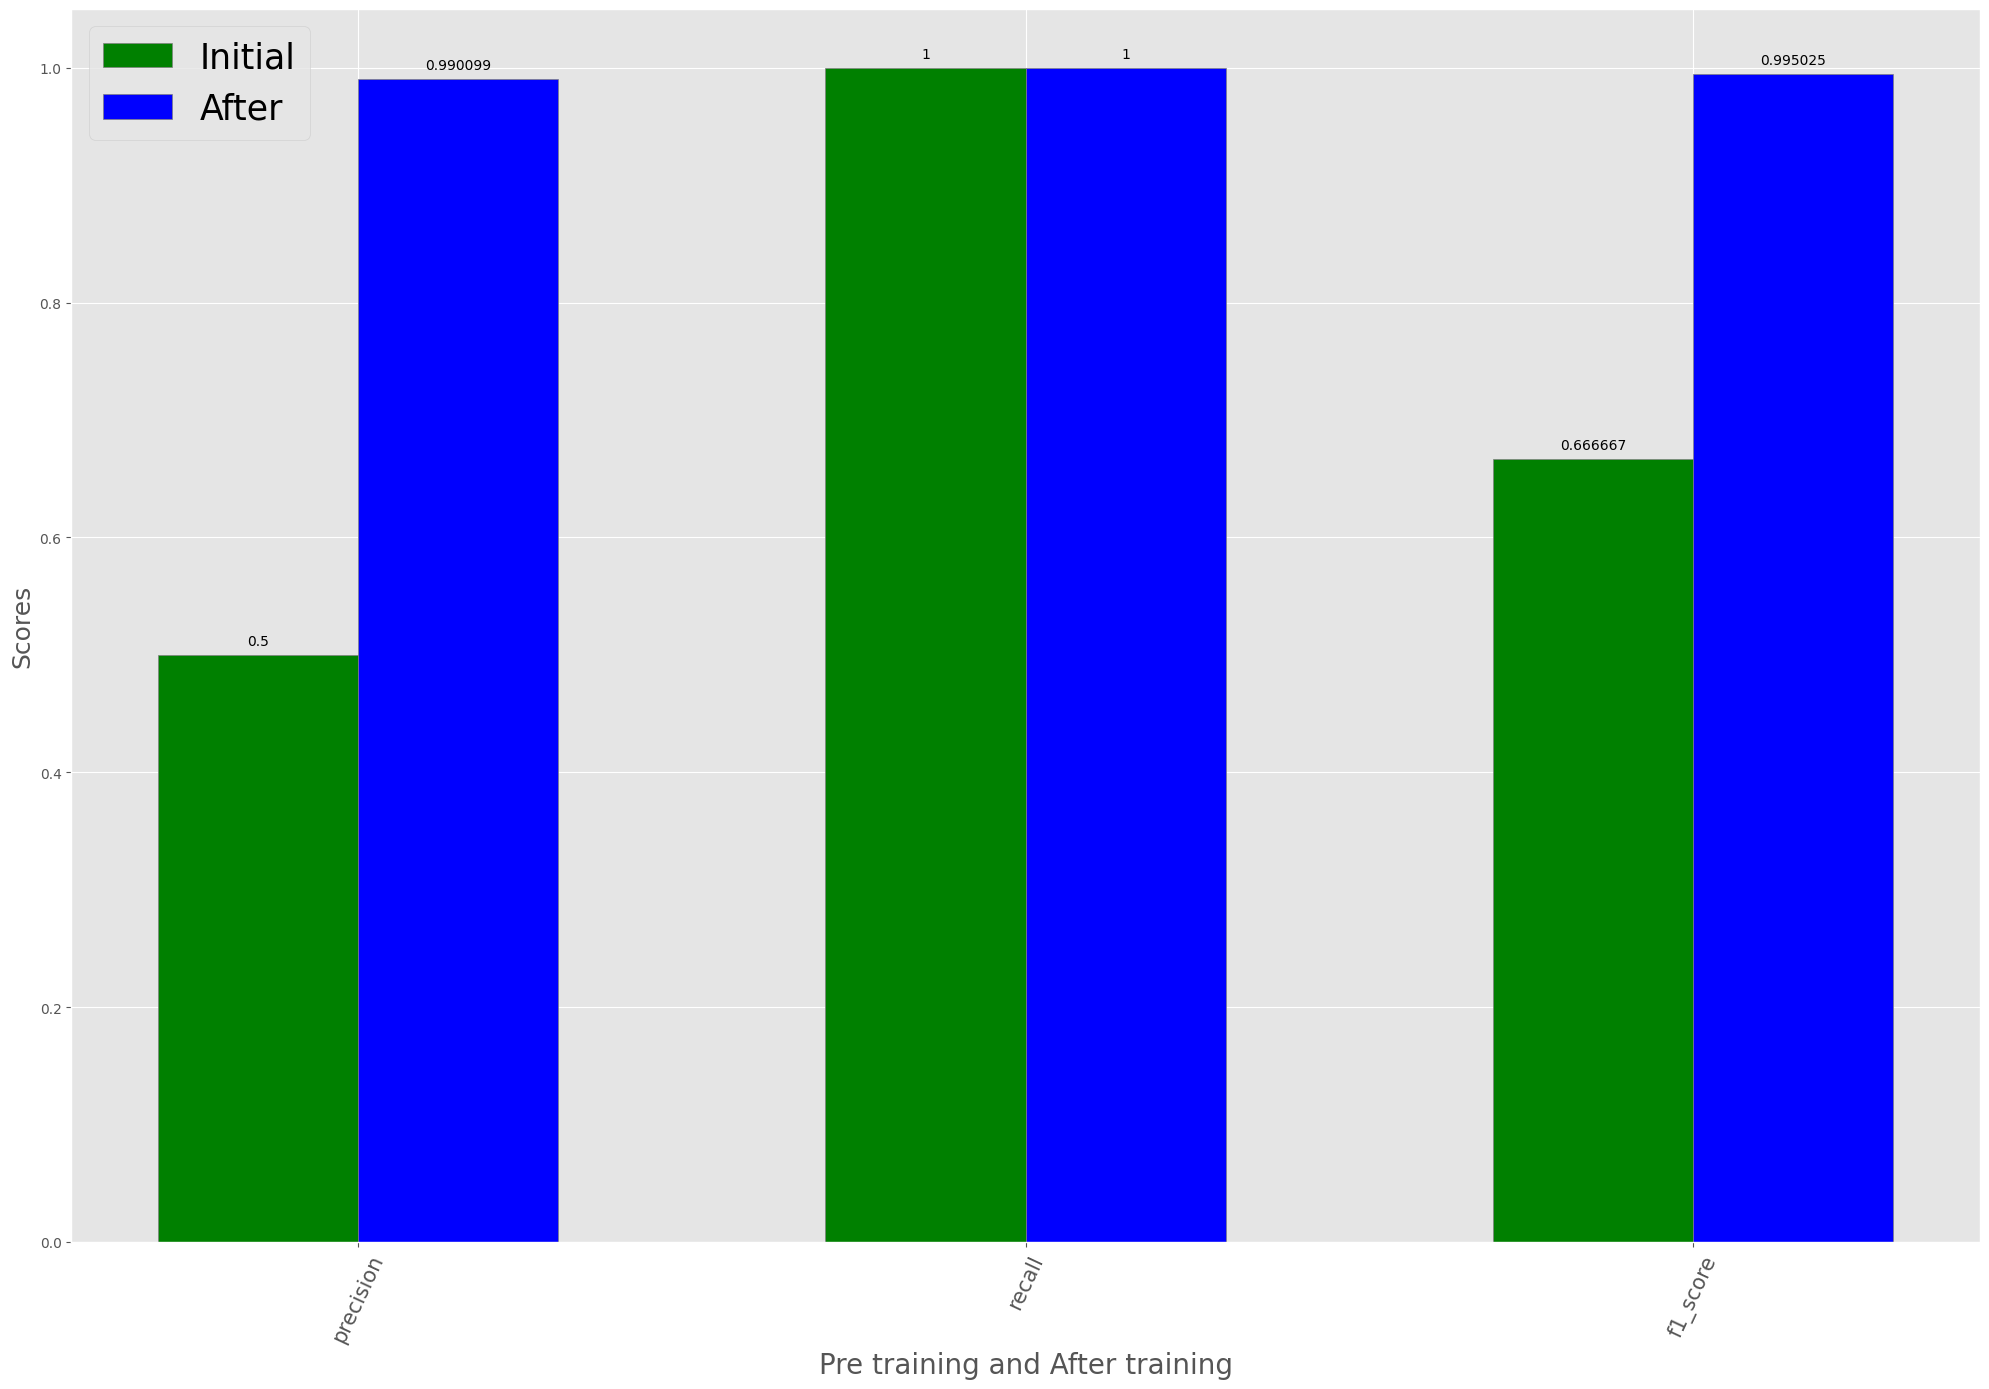

In [126]:
evaluation_data = [perceptron_conf(values[3]), perceptron_conf(values[2])]
plt.style.use('ggplot')


# Set position of bar on X axis
bar_width = 0.3
labels = ['precision', 'recall', 'f1_score']
fig, ax = plt.subplots(figsize =(20, 14))
x = np.arange(len(labels))

 
# Make the plot
rects1 = plt.bar(x - bar_width/2, evaluation_data[0][0:3], color ='g', width = bar_width,
        edgecolor ='grey', label ='Initial', align='center')
rects2 = plt.bar(x + bar_width/2, evaluation_data[1][0:3], color ='b', width = bar_width,
        edgecolor ='grey', label ='After', align='center')

ax.set_xticks(x, labels)
ax.legend(loc='best', fontsize=25)
ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)
ax.tick_params(axis='x', labelrotation=65)
plt.xticks(fontsize=15)
plt.ylabel('Scores', fontsize=18)
plt.xlabel('Pre training and After training', fontsize=20)
fig.tight_layout()
fig.savefig('../assets/figure5.png')
plt.show()

### Perceptron Optimal Threshold

In [128]:
def perceptron_optimal_threshold():
    thres_dict = {2 : [0, 0], 3 : [0, 0],
                  4 : [0, 0], 5 : [0, 0],
                  6 : [0, 0], 7 : [0, 0],
                  8 : [0, 0], 9 : [0, 0]}
    optimal_thres = 0

    for counter, ds in enumerate(challenge_ds):
        x = ds[0:784]
        y_label = int(ds[784])
        challenge_input = np.dot(np.transpose(x), values[2])
        y_value = 1 if challenge_input > optimal_thres else 0
        if y_value == 0:
            thres_dict[y_label][0] += 1
        elif y_value == 1:
            thres_dict[y_label][1] += 1
    df = pd.DataFrame(thres_dict)
    return df

print(perceptron_optimal_threshold())

    2   3   4   5   6   7   8   9
0  31  39  30  67  55  11  31  30
1  69  61  70  33  45  89  69  70


### Heat Map

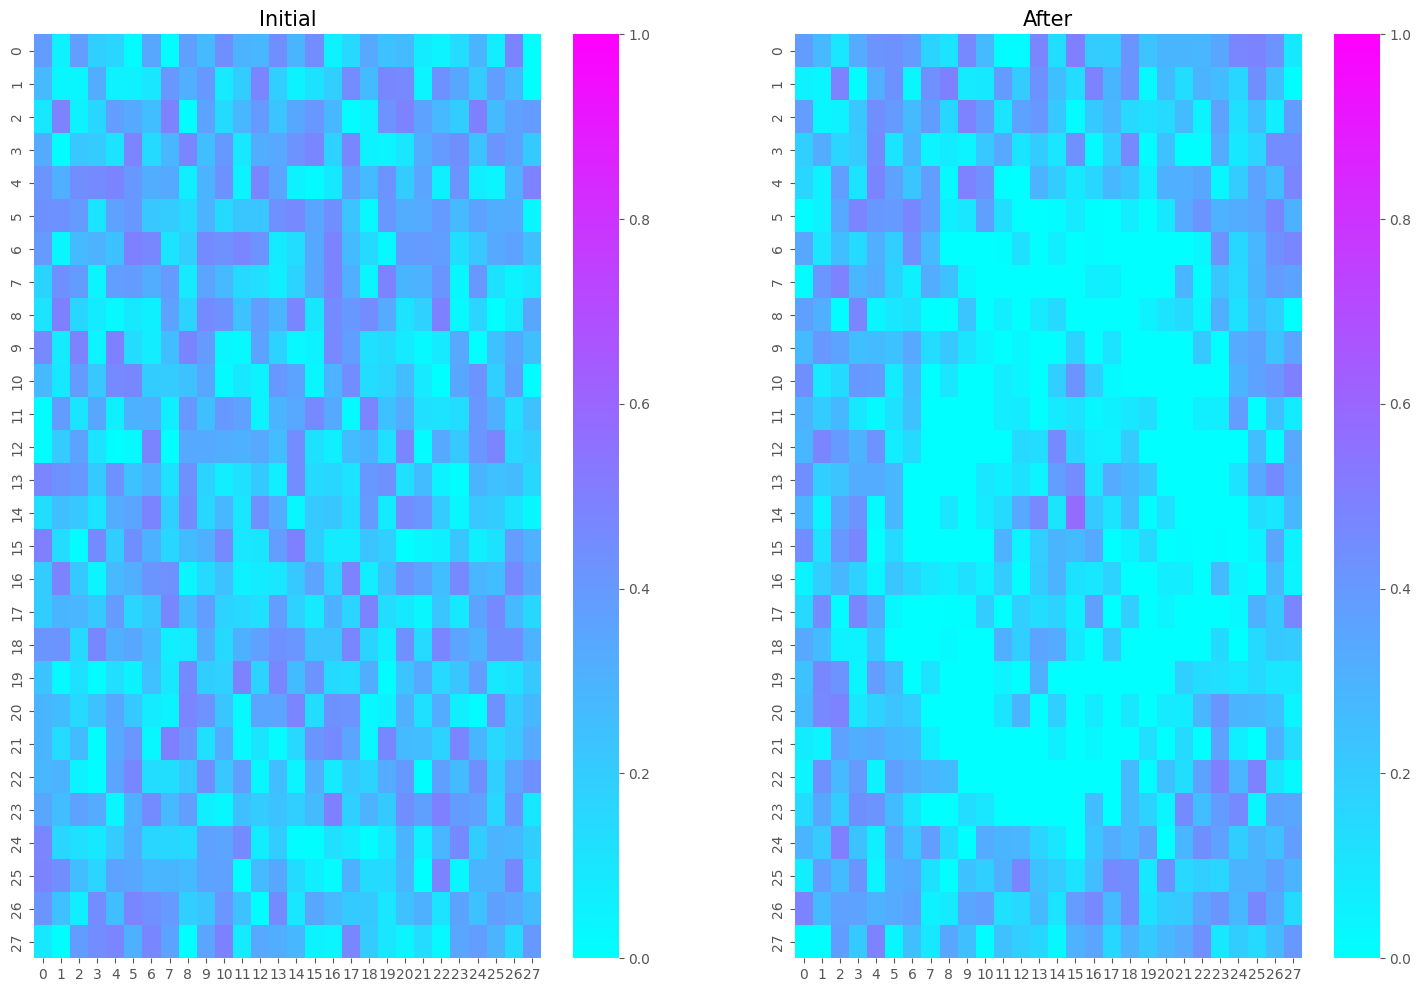

In [119]:
init_w = np.asarray(values[3])
final_w = np.asarray(values[2])
init_w_img = init_w.reshape(28, 28)
final_w_img = final_w.reshape(28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

sns.heatmap(init_w_img, ax=ax1, vmin=0, vmax=1, cmap = 'cool', label='Initial')
sns.heatmap(np.transpose(final_w_img), ax=ax2, vmin=0, vmax=1, cmap = 'cool', label='After')
ax1.set_title('Initial', fontsize=15)
ax2.set_title('After', fontsize=15)
plt.savefig('../assets/figure6.png')
plt.show()